In [ ]:
"""
    Attempts to comprehend teams' rankings:
    1. Understanding final ranking in the league due to given situations
    2. Proof of clustering team's performance on promotions
"""

In [123]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [124]:
class Attr:
    def __init__(self, name, value, color=None):
        self.name = name
        self.value = value
        self.color = color

In [125]:
def get_value(attr):
    return attr.value

In [126]:
def sorted_class(names, values, color=None):
    attrs = []
    for i in range(0, len(names)):
        attrs.append(Attr(names[i], values[i]))
    attrs.sort(key=get_value)
    new_names = []
    new_values = []
    for i in range(0, len(names)):
        new_names.append(attrs[i].name)
        new_values.append(attrs[i].value)
    return new_names, new_values

In [127]:
def encode_data(df, df_column):
    elements = np.unique(df[df_column].astype(str))
    print(len(elements))
    print(elements)
    enc = preprocessing.LabelEncoder()
    enc.fit(elements)
    return enc.transform(df[df_column].astype(str))

In [ ]:
def encode_description(df):
    

In [128]:
def score_home(best):
    if best != 0:
        return int(best[0]) - int(best[2])
    return best

In [129]:
def score_away(best):
    if best != 0:
        return int(best[2]) - int(best[0])
    return best

In [130]:
def clean_data(df):
    df = df.drop(df.columns[0], axis=1)
    df = df.drop(columns=["team.name","season","league","goals_diff","form","group","stats_home.played","stats_away.played",
                          "stats_home.wins", "stats_away.wins", "stats_home.goals_for", "stats_home.goals_against",
                         "stats_away.goals_for", "stats_away.goals_against",], axis=1)
    # Encode description (Promotion: either Champions, UEFA Europe, Second division)
    df["description"] = encode_data(df, "description")
    # None values set to 0
    df.fillna(value=0, inplace=True)
    # For best_lose
    df["stats_home.streaks.best_lose"] = df["stats_home.streaks.best_lose"].apply(score_home)
    df["stats_away.streaks.best_lose"] = df["stats_away.streaks.best_lose"].apply(score_away)
    # For best_win
    df["stats_home.streaks.best_win"] = df["stats_home.streaks.best_win"].apply(score_home)
    df["stats_away.streaks.best_win"] = df["stats_away.streaks.best_win"].apply(score_away)
    return df

In [131]:
def get_target(df, label):
    target = []
    for index, row in df.iterrows():
        target.append(row[label])
    return target

In [132]:
# Label is the set of columns to keep as target
def df_season(country, league, season, label, drop_others=None):
    dirCountry = '../' + country + '/'
    dirName = dirCountry + league + '/' + str(season) + '/'
    file_title = str(season) + '.csv'
    csv_file = dirName + file_title
    df = pd.read_csv(csv_file)
    df = clean_data(df)
    target = []
    for l in label:
        target = target + [get_target(df, l)]
    df = df.drop(columns=label, axis=1)
    if drop_others != None:
        df = df.drop(columns=drop_others, axis=1)
    return df, target

In [133]:
def weights_graph(axs, row, season, model, val, rmse, r_sq, weights, x_label):
    title = str(season) + ' ' + model + ' ' + val
    rmse_txt = "RMSE: " + '{0:.2f}'.format(rmse)
    r_txt = "R^2: " + '{0:.2f}'.format(r_sq)
    x_label, weights = sorted_class(x_label, weights)
    axs[row].bar(x_label, weights)
    axs[row].set_title(title)
    axs[row].text(1, 1.1, rmse_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].text(1, 1.2, r_txt, color="b", fontsize=10, horizontalalignment='center', verticalalignment='center',
     transform = axs[row].transAxes)
    axs[row].tick_params(axis='x', labelrotation=90)
    for i in range(len(x_label)):
        axs[row].annotate('{0:.2f}'.format(weights[i]), xy=(x_label[i], weights[i]), verticalalignment='bottom')
    return axs

In [134]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score

In [135]:
def ols_ridge(season, data, target, test_len=None, cross_val=None):
    r = 2
    fig, axs = plt.subplots(r)
    fig.set_size_inches(18.5, 10.5)
    # Create index mat
    mat = [j for j in range(0, r)]
    i = 0
    
    x_label = data.columns
    if test_len != None:
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_len, random_state=0)
    classifiers = dict(ols=linear_model.LinearRegression(), ridge=linear_model.Ridge(alpha=.1))
    
    for name, clf in classifiers.items():
        if cross_val != None:
            clf_mse = cross_validate(clf, data, target, cv=cross_val, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True, return_estimator=True)
            mse_sqr = np.sqrt(clf_mse['test_neg_mean_squared_error'].mean()*-1)
            mse_r = np.sqrt(clf_mse['test_r2'].mean())
            coef = []
            for model in clf_mse['estimator']:
                coef.append(model.coef_)
            final_coef = np.matrix(coef)
            final_coef = final_coef.mean(0)
            final_coef = np.array(final_coef).flatten()
            axs = weights_graph(axs, mat[i], season, name, "cv-5", mse_sqr, mse_r, final_coef, x_label)
        else:
            clf.fit(X_train, y_train)
            Y = clf.predict(X_test)
            mse = mean_squared_error(y_test, Y)
            axs = weights_graph(axs, mat[i], season, name, "train-test", np.sqrt(mse), clf.score(X_test, y_test), clf.coef_, x_label)
        i = i + 1
    
    fig.tight_layout()
    plt.show()

In [136]:
# League directory
country = 'ES'
league = '140'
curr_week = 38

In [137]:
# Historicity: multi season directory
year_window = 4
start_season = 2019
seasons = list(range(start_season, start_season - year_window, -1))
print(seasons)

[2019, 2018, 2017, 2016]


In [138]:
# Data initialization
data = []
# Targets
target_col = ["rank", "points", "description"]
for season in seasons:
    df, target = df_season(country, league, season, target_col)
    tup = (season, df, target)
    data.append(tup)

5
['Promotion - Champions League (Group Stage)'
 'Promotion - Europa League (Group Stage)'
 'Promotion - Europa League (Qualification)' 'Relegation - LaLiga2' 'nan']
5
['Promotion - Champions League (Group Stage)'
 'Promotion - Europa League (Group Stage)'
 'Promotion - Europa League (Qualification)' 'Relegation - LaLiga2' 'nan']
4
['Relegation' 'UEFA Champions League' 'UEFA Europa League' 'nan']
5
['Relegation' 'UEFA Champions League' 'UEFA Champions League Qualifiers'
 'UEFA Europa League' 'nan']


In [139]:
"""
    Here we have a dataset with the 4 years together
"""
all_data = pd.DataFrame()
all_target = [ [] for _ in range(len(target_col)) ]
for d in data:
    all_data = all_data.append(d[1])
    i = 0
    for target in d[2]:
        all_target[i] = all_target[i] + target
        i = i + 1
print(all_target)

[[5.0, 19.0, 9.0, 15.0, 7.0, 2.0, 14.0, 16.0, 18.0, 3.0, 12.0, 17.0, 11.0, 4.0, 20.0, 1.0, 8.0, 6.0, 13.0, 10.0, 14.0, 4.0, 10.0, 1.0, 12.0, 11.0, 13.0, 2.0, 15.0, 17.0, 8.0, 6.0, 18.0, 7.0, 19.0, 20.0, 3.0, 5.0, 9.0, 16.0, 5.0, 18.0, 20.0, 3.0, 8.0, 19.0, 1.0, 7.0, 16.0, 12.0, 2.0, 17.0, 9.0, 13.0, 6.0, 10.0, 15.0, 4.0, 11.0, 14.0, 5.0, 14.0, 18.0, 11.0, 12.0, 15.0, 16.0, 20.0, 2.0, 10.0, 9.0, 17.0, 3.0, 13.0, 7.0, 4.0, 8.0, 1.0, 6.0, 19.0], [60.0, 33.0, 53.0, 41.0, 56.0, 82.0, 42.0, 39.0, 36.0, 70.0, 49.0, 37.0, 51.0, 70.0, 25.0, 87.0, 54.0, 56.0, 42.0, 52.0, 44.0, 61.0, 50.0, 87.0, 47.0, 50.0, 45.0, 76.0, 44.0, 41.0, 53.0, 59.0, 37.0, 53.0, 33.0, 32.0, 68.0, 59.0, 50.0, 41.0, 37.0, 18.0, 13.0, 43.0, 33.0, 17.0, 59.0, 35.0, 25.0, 29.0, 52.0, 20.0, 32.0, 28.0, 36.0, 31.0, 26.0, 42.0, 30.0, 26.0, 67.0, 39.0, 31.0, 46.0, 46.0, 39.0, 36.0, 20.0, 90.0, 54.0, 55.0, 35.0, 78.0, 45.0, 63.0, 72.0, 56.0, 93.0, 64.0, 22.0], [1.0, 3.0, 4.0, 4.0, 2.0, 0.0, 4.0, 4.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.0, 

In [140]:
all_data.head()

,team.id,stats_home.draws,stats_home.lose,stats_home.avg_goals_for,stats_home.avg_goals_against,stats_home.clean_sheet,stats_home.failed_to_score,stats_home.streaks.wins,stats_home.streaks.draws,stats_home.streaks.loses,...,stats_away.avg_goals_against,stats_away.clean_sheet,stats_away.failed_to_score,stats_away.streaks.wins,stats_away.streaks.draws,stats_away.streaks.loses,stats_away.streaks.best_win,stats_away.streaks.best_lose,stats_away.streaks.best_goals_for,stats_away.streaks.best_goals_against
0,533,5,5,1.9,1.3,7,2,3,1,3,...,1.3,5,1,3,1,3,3,3,3,3
1,798,3,8,1.3,1.2,5,7,2,1,3,...,2.3,0,11,2,1,3,1,1,3,5
2,532,7,1,1.5,0.8,7,1,2,2,3,...,1.9,1,8,2,2,3,2,2,4,5
3,543,4,6,1.8,1.4,3,1,3,2,2,...,1.7,3,9,3,2,2,1,1,2,5
4,715,3,6,1.4,0.8,8,3,3,2,3,...,1.5,5,7,3,2,3,3,3,4,4


In [141]:
print(all_data.shape)

(80, 27)


In [142]:
# Target 0 : rank
# Target 1 : points
# Target 2: description
print(len(all_target[0]))

80


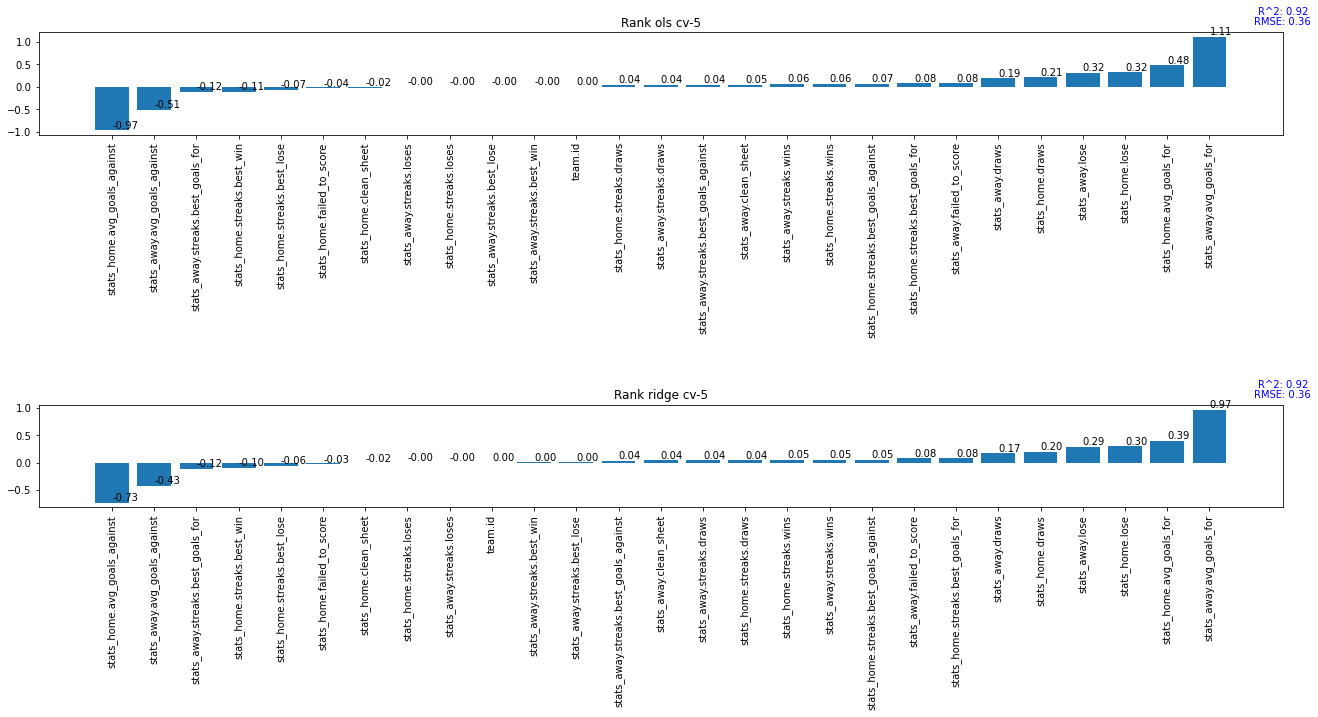

In [163]:
"""
    Rank fit
"""
# Before scalate the target
new_target = preprocessing.scale(all_target[0])
ols_ridge("Rank", all_data, new_target, cross_val = 5)

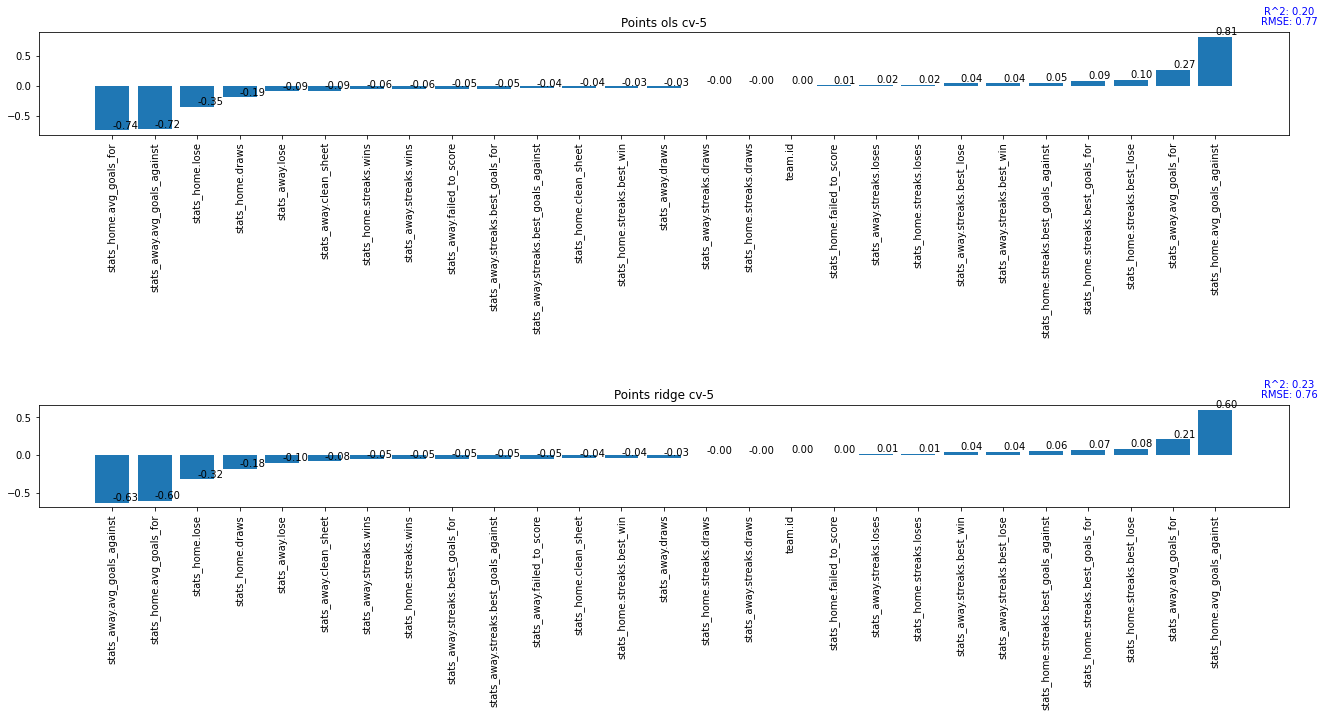

In [164]:
"""
    Points fit
"""
new_target = preprocessing.scale(all_target[1])
ols_ridge("Points", all_data, new_target, cross_val = 5)

In [ ]:
"""
    Clustering the description
"""